In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

In [2]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform = None):
        super().__init__()
        self.images_dir = image_dir
        self.annotations_dir = annotation_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, index):
        image = Image.open(self.images_dir[index]).convert('RGB')
        label = self.parse_annotation(self.annotations_dir[index])
        
        if self.transform != None:
            image = self.transform(image)

        return image, label 

    
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Khởi tạo label
        label = None

        for obj in root.findall('object'):
            name = obj.find('name').text
            if label is None:
                label = name

        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1
        return label_num

In [3]:
def get_count_filename_obj(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    count = 0

    for obj in root.findall('object'):
        count += 1
    return count


def filter_images_with_multiple_obj(images_path, annotations_paths):
        valid_img_paths = []
        valid_img_annotation_paths = []
        for index, annotation_path in enumerate(annotations_paths):
            count = get_count_filename_obj(annotation_path)
            if count <= 1:
                valid_img_paths.append(images_path[index])
                valid_img_annotation_paths.append(annotations_paths[index])
            else:
                print(
                    f"Image {images_path[index]} has multiple objects and will be excluded from the dataset")

        print(f"Total has {len(valid_img_paths)} valid image")

        return valid_img_paths, valid_img_annotation_paths

In [4]:
# Data directory
annotations_dir = '/kaggle/input/dog-and-cat-detection/annotations'
image_dir = '/kaggle/input/dog-and-cat-detection/images'

image_files = [os.path.join(image_dir, f) for f in os.listdir(
    image_dir) if os.path.isfile(os.path.join(image_dir, f))]
annotations_files = [os.path.join(annotations_dir, f) for f in os.listdir(
    annotations_dir) if os.path.isfile(os.path.join(annotations_dir, f))]

# filter image > 1 obj

image_files, annotations_files = filter_images_with_multiple_obj(image_files, annotations_files)

x_train, x_val, y_train, y_val = train_test_split(
    image_files, annotations_files, test_size=0.2, random_state=42)

# Output the result
print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))

y_train[0]

Image /kaggle/input/dog-and-cat-detection/images/Cats_Test1747.png has multiple objects and will be excluded from the dataset
Total has 3685 valid image
Training set size: 2948
Validation set size: 737


'/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1919.xml'

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(x_train, y_train, transform=transform)
val_dataset = ImageDataset(x_val, y_val, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Labels: tensor([1, 1, 0, 0, 1, 1, 1, 1])


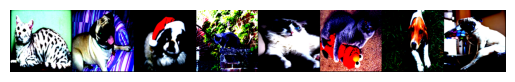

In [6]:
import matplotlib.pyplot as plt
import torchvision

# Hàm để hiển thị hình ảnh
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')  # Ẩn trục tọa độ
    plt.show()


# Lấy một batch từ train_loader và hiển thị ảnh
for i, (input_img, labels) in enumerate(train_loader, 0):
    print(f"Labels: {labels[:8]}")  # In nhãn của 8 ảnh đầu tiên
    # Hiển thị 8 ảnh đầu tiên
    imshow(torchvision.utils.make_grid(input_img[:8]))
    break  # Thoát khỏi vòng lặp sau batch đầu tiên

### Xây dựng model

In [7]:
# Model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: cat and dog

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Show model summary
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass
            scores = model(data)
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum().item()
            total += targets.size(0)

    # Print validation accuracy
    accuracy = float(correct) / float(total) * 100
    print(
        f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.2f}%")

Epoch 1/20, Validation Accuracy: 68.25%
Epoch 2/20, Validation Accuracy: 68.25%
Epoch 3/20, Validation Accuracy: 68.25%
Epoch 4/20, Validation Accuracy: 68.25%
Epoch 5/20, Validation Accuracy: 68.39%
Epoch 6/20, Validation Accuracy: 68.25%
Epoch 7/20, Validation Accuracy: 68.25%
Epoch 8/20, Validation Accuracy: 68.25%
Epoch 9/20, Validation Accuracy: 64.72%
Epoch 10/20, Validation Accuracy: 68.25%
Epoch 11/20, Validation Accuracy: 68.25%
Epoch 12/20, Validation Accuracy: 68.25%
Epoch 13/20, Validation Accuracy: 68.11%
Epoch 14/20, Validation Accuracy: 68.52%
Epoch 15/20, Validation Accuracy: 68.39%
Epoch 16/20, Validation Accuracy: 68.25%
Epoch 17/20, Validation Accuracy: 68.11%
Epoch 18/20, Validation Accuracy: 68.25%
Epoch 19/20, Validation Accuracy: 58.34%
Epoch 20/20, Validation Accuracy: 68.25%
